# plot_model_architecture
- Creating visualisation for readme.md of CNN model architecture

In [9]:
import sdss_model_constructors
import kerastuner as kt
import tensorflow as tf
import numpy as np
from sklearn import model_selection
from keras.preprocessing.image import ImageDataGenerator

In [10]:
data_dir = '../../data/cleaned_datasets/'

x = np.load(data_dir + 'x.npy')
y = np.load(data_dir + 'y.npy')

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# creating training sample
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 1 - train_ratio)

# creating test and validation training samples.
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio)) 
y_train.shape, y_val.shape, y_test.shape

train_gen = ImageDataGenerator(rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 45)
                               zoom_range = 0.25, # zoom range between 0.75 and 1.25 original size
                               horizontal_flip = True,
                               vertical_flip = True,
                               width_shift_range=0.05, # shifting centre by up-to 5%
                               height_shift_range=0.05) # shifting centre by up-to 5%

train_gen.fit(X_train)

In [11]:
tuner = kt.Hyperband(sdss_model_constructors.build_tuning_CNN,
                     objective = 'val_loss', # model evaluation metric
                     max_epochs = 8, # The maximum number of epochs to train one model. 
                     factor = 3, # Reduction factor for the number of epochs and number of models for each bracket.
                     directory = './tuning',
                     project_name = 'filter_tuning') 

# Before running the hyperparameter search, define a callback to clear the training outputs 
# at the end of every training step.

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project ./tuning/filter_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./tuning/filter_tuning/tuner0.json


In [12]:
tuner.search(train_gen.flow(X_train, y_train), 
             epochs = 10, 
             validation_data = (X_val, y_val),
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

INFO:tensorflow:Oracle triggered exit


In [14]:
model = sdss_model_constructors.build_tuning_CNN(best_hps)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 75, 64)        6976      
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 96)        153696    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 96)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 35, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       49280     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)      

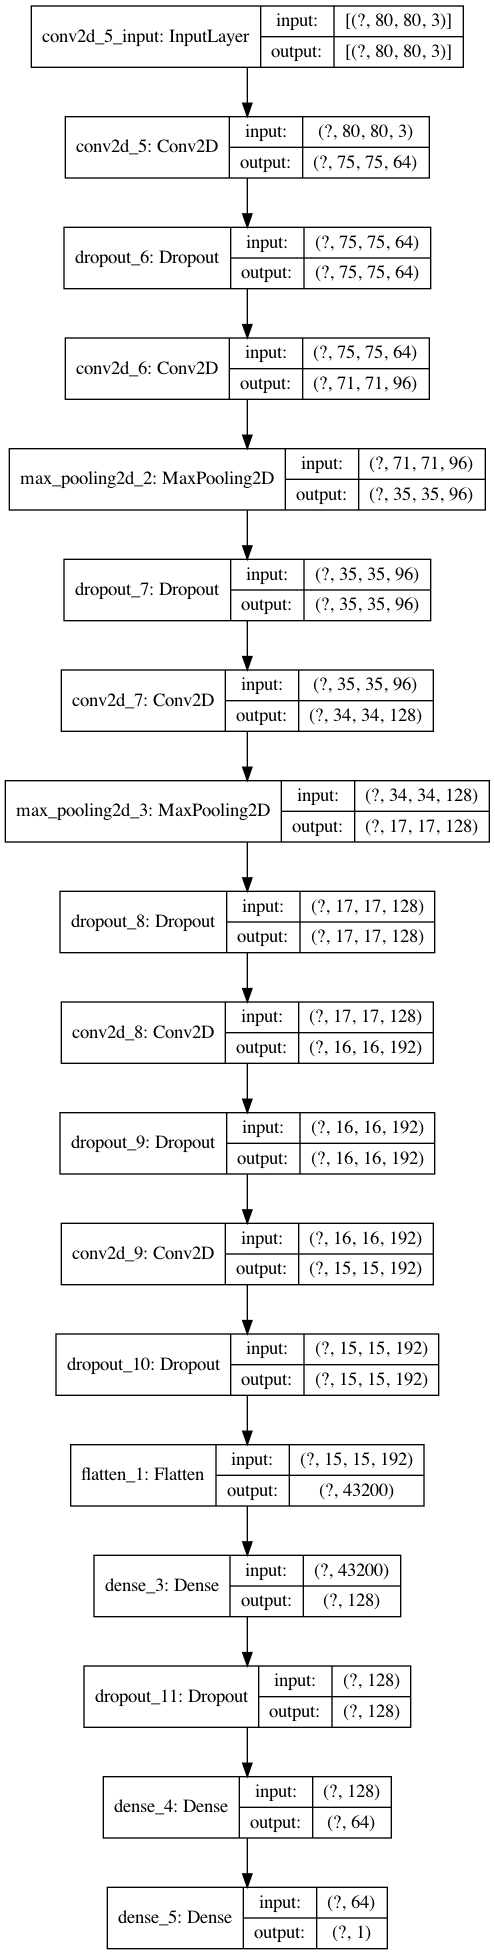

In [15]:
dot_img_file = '../../plots/tf_model_plot.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)